# Loading Basic dependencies

In [1]:
#loading basic dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
#loading the data
data = pd.read_csv('Customers_in_a_Shop.csv',header=None)
data.columns = ['Date','Customers']
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m")
data = data.set_index('Date')

#shape of the data
data.shape

(144, 1)

# Missing Values

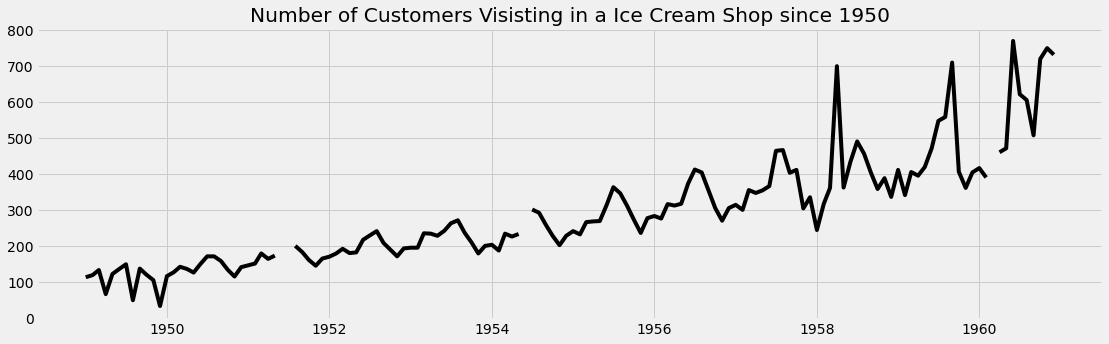

In [3]:
plt.rcParams['figure.figsize']=(17,5)
plt.plot(data,color='black')
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

# Linear Interpolation

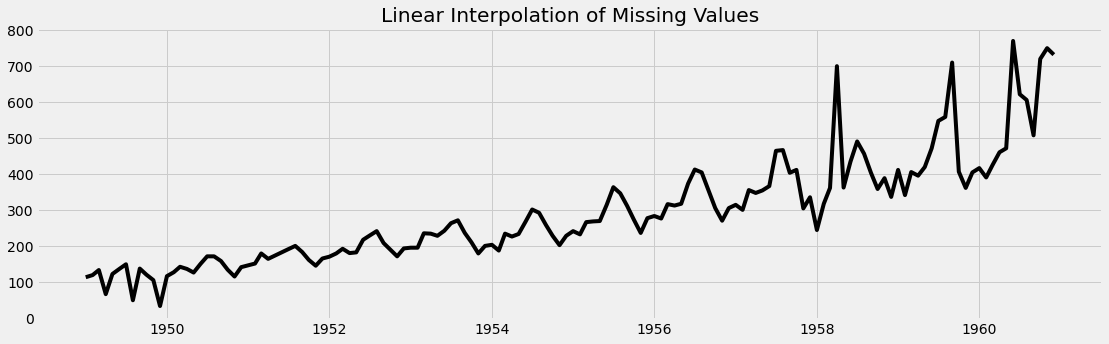

In [4]:
plt.rcParams['figure.figsize']=(17,5)
data['Customers_linear']=data['Customers'].interpolate(method='linear')
plt.plot(data['Customers_linear'],color='black')
plt.title("Linear Interpolation of Missing Values")
plt.show()

# Outliers

In [5]:
# outliers treatment

#data['Customers_linear'].loc[(data['Customers_linear']>=700)] = 622

# Non-Stationary to Stationary Series
## Box Cox Transformation

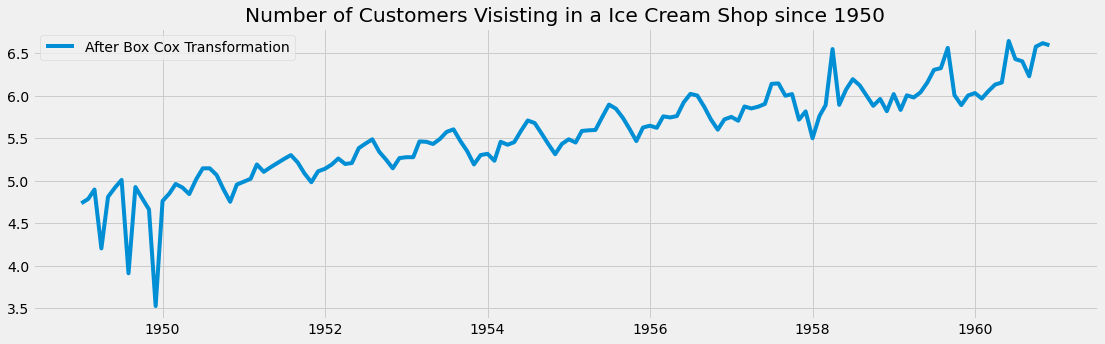

In [6]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Customers_linear'],lmbda=0),index=data.index)
plt.plot(data_boxcox, label="After Box Cox Transformation")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## Differencing

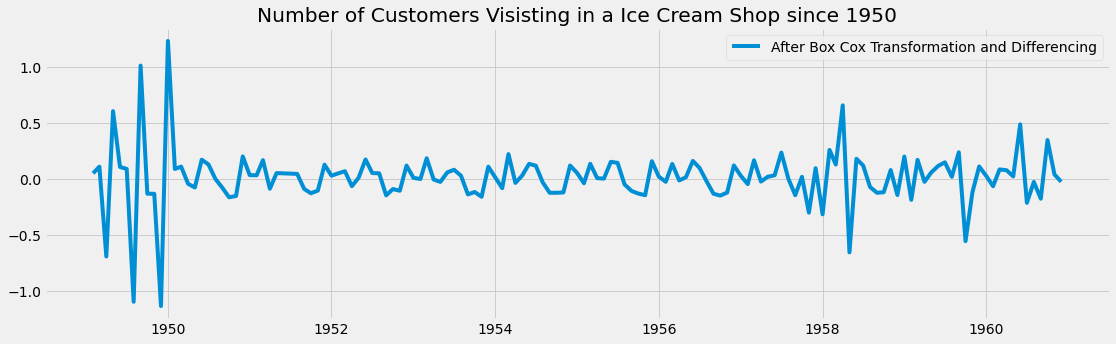

In [7]:
data_boxcox_difference= pd.Series(data_boxcox-data_boxcox.shift(), index=data.index)
data_boxcox_difference.dropna(inplace=True)
plt.plot(data_boxcox_difference, label="After Box Cox Transformation and Differencing")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

# Auto Correlation function

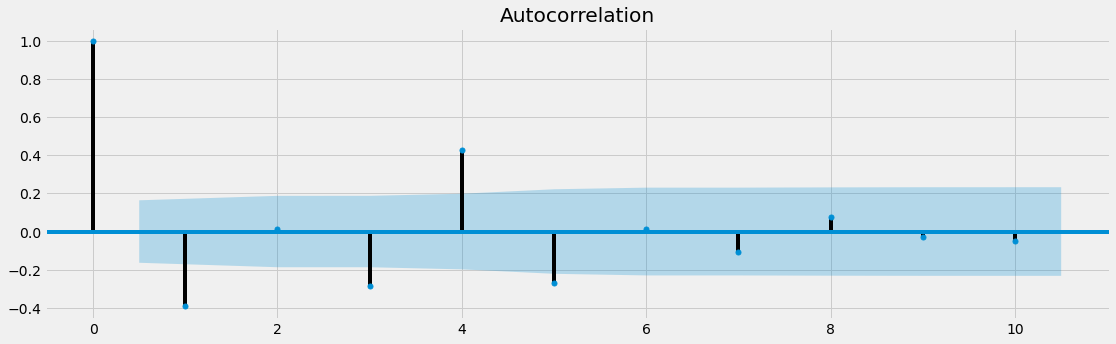

In [8]:
#Loading and plotting acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_boxcox_difference, ax=plt.gca(), lags=10)
plt.show()

# Partial Correlation function

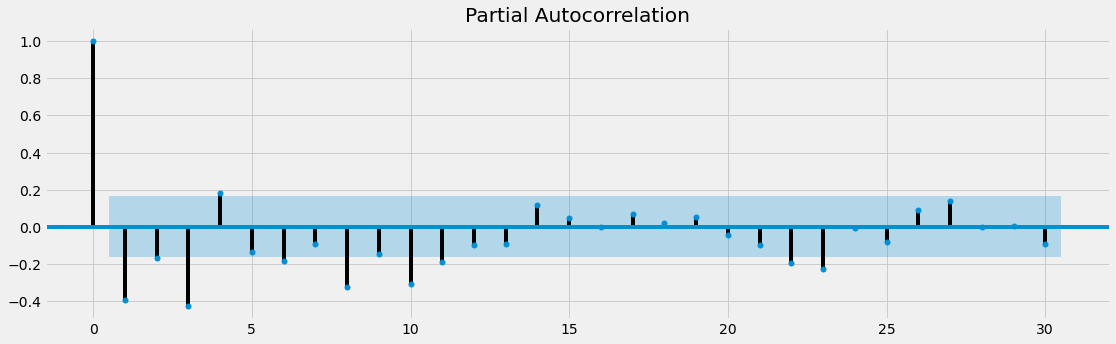

In [9]:
#Loading and plottin pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_boxcox_difference, ax=plt.gca(), lags=30)
plt.show()

# Splitting into Train and Test dataset

In [10]:
length_train = 115
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,:]

In [11]:
train_data_boxcox = data_boxcox[:length_train]
test_data_boxcox = data_boxcox[length_train:]
train_data_boxcox_difference = data_boxcox_difference[:length_train-1]
test_data_boxcox_difference = data_boxcox_difference[length_train-1:]  

# Auto Regressive Integrated Moving Average Model (ARIMA)

It transform the time series using Box Cox and then itself takes care of the differencing and remove the trend from the time series.

We have three parameters to be used:-

p is the highest lag in the model

d is the degree of differencing to make the series stationary

q is the number of past errors terms included

In [12]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data_boxcox, order=(5,1,2))
model_fit = model.fit()
print(model_fit.params)

C:\Users\SYS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\SYS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const        0.013211
ar.L1.D.y    1.023382
ar.L2.D.y   -0.305348
ar.L3.D.y   -0.293684
ar.L4.D.y    0.548231
ar.L5.D.y   -0.631379
ma.L1.D.y   -1.888935
ma.L2.D.y    1.000000
dtype: float64


C:\Users\SYS\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\SYS\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Recover Time Series Data

In [13]:
y_arima_new = data_boxcox_difference.copy()
y_arima_new['arima_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(),
                                                                    data_boxcox_difference.index.max())
y_arima_new['arima_forecast_boxcox'] = y_arima_new['arima_forecast_boxcox_difference'].cumsum()
y_arima_new['arima_forecast_boxcox'] = y_arima_new['arima_forecast_boxcox'].add(data_boxcox[0])
y_arima_new['arima_forecast'] = np.exp(y_arima_new['arima_forecast_boxcox'])

# Plotting Train, Test and Forecast

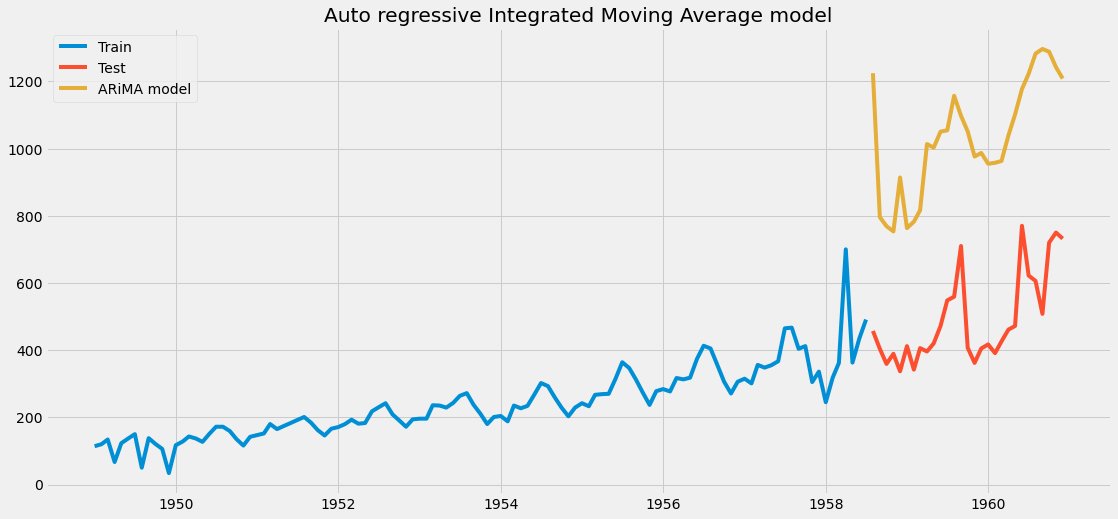

In [14]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_arima_new['arima_forecast'][test.index.min():], label = 'ARiMA model')

plt.legend()
plt.title('Auto regressive Integrated Moving Average model')
plt.show()

# Seasonal Auto Regressive Integrated Moving Average Model (SARIMA)

SARIMA model brings all the features of ARIMA model along with the seasonality.

The key elements performed in SARIMA are:-

1. The time series is differenced to make it stationary.

2. The SARIMA equation is a linear combination of past observations and past errors.

3. Seasonal differencing is performed on the time series.

4. SARIMA models future seasonality as a linear combination of past seasonality observations and past seasonality errors.


In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox_difference, order=(1,1,1), seasonal_order=(1,1,1,6))
model_fit = model.fit()
print(model_fit.params)

C:\Users\SYS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\SYS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ar.L1     -0.570245
ma.L1     -0.998473
ar.S.L6   -0.736076
ma.S.L6   -0.521615
sigma2     0.052073
dtype: float64


# Recover Original Time Series Data

In [19]:
y_sarima_new = data_boxcox_difference.copy()
y_sarima_new['sarima_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(),
                                                                      data_boxcox_difference.index.max())
y_sarima_new['sarima_forecast_boxcox'] = y_sarima_new['sarima_forecast_boxcox_difference'].cumsum()
y_sarima_new['sarima_forecast_boxcox'] = y_sarima_new['sarima_forecast_boxcox'].add(data_boxcox[0])
y_sarima_new['sarima_forecast'] = np.exp(y_sarima_new['sarima_forecast_boxcox'])

# Plotting Train, Test and Forecasted data

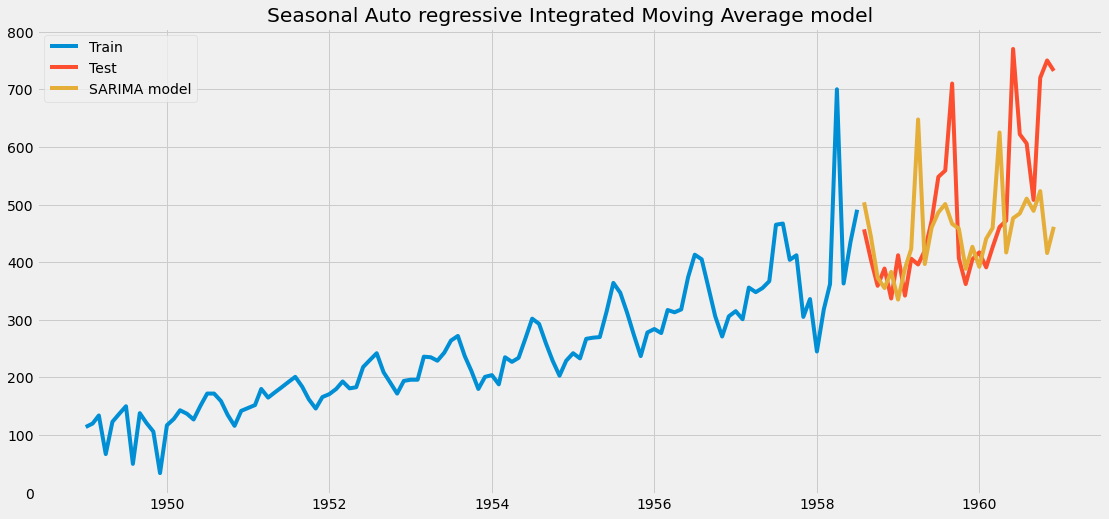

In [20]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_sarima_new['sarima_forecast'][test.index.min():], label = 'SARIMA model')

plt.legend()
plt.title('Seasonal Auto regressive Integrated Moving Average model')
plt.show()